<a href="https://colab.research.google.com/github/MamMates/ml-food-classification/blob/main/MamMates_Food_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MamMates - Food Classification

Food Classification using CNN

## Preprequites

https://pypi.org/project/gdown





In [1]:
!pip install gdown

## Import neccessary library

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import gdown
import matplotlib.image as mpimg
from google.colab import files
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

## Download dataset

In [3]:
url = "https://drive.google.com/file/d/1Lh1WKPNpvBi05mRC22fmyE19c85ZeS9-/view?usp=sharing"
gdown.download(url, quiet=True, fuzzy=True)

'dataset.zip'

In [4]:
dataset_path = "dataset.zip"
extract_location = "/dataset"
zip_extractor = zipfile.ZipFile(dataset_path, 'r')
zip_extractor.extractall(extract_location)
zip_extractor.close()

In [5]:
import os
for root, dirs, _ in os.walk(extract_location):
  for i in dirs:
    print(os.path.join(root, i))

/dataset/Dataset Klasifikasi Makanan
/dataset/Dataset Klasifikasi Makanan/Kue Cubit
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur
/dataset/Dataset Klasifikasi Makanan/Donat
/dataset/Dataset Klasifikasi Makanan/Putu Ayu
/dataset/Dataset Klasifikasi Makanan/Roti
/dataset/Dataset Klasifikasi Makanan/Kue Klepon
/dataset/Dataset Klasifikasi Makanan/Dadar Gulung
/dataset/Dataset Klasifikasi Makanan/Kue Lapis
/dataset/Dataset Klasifikasi Makanan/Kue Risoles
/dataset/Dataset Klasifikasi Makanan/Bika Ambon
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur/test
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur/validation
/dataset/Dataset Klasifikasi Makanan/Kue Lumpur/train
/dataset/Dataset Klasifikasi Makanan/Roti/test
/dataset/Dataset Klasifikasi Makanan/Roti/validation
/dataset/Dataset Klasifikasi Makanan/Roti/train
/dataset/Dataset Klasifikasi Makanan/Kue Klepon/test
/dataset/Dataset Klasifikasi Makanan/Kue Klepon/validation
/dataset/Dataset Klasifikasi Makanan/Kue Klepon/train
/dataset/Datase

In [6]:
base_dir = os.path.join(extract_location, 'Dataset Klasifikasi Makanan')
temp = os.listdir(base_dir)
temp, len(temp)

(['Kue Cubit',
  'Kue Lumpur',
  'Donat',
  'Putu Ayu',
  'Roti',
  'Kue Klepon',
  'Dadar Gulung',
  'Kue Lapis',
  'Kue Risoles',
  'Bika Ambon'],
 10)

In [7]:
not_splitted = []
for i in temp:
  curr_path = os.path.join(base_dir, i)
  print(i) if len(os.listdir(curr_path)) == 3 else not_splitted.append(i)

Kue Lumpur
Roti
Kue Klepon
Kue Lapis
Kue Risoles


In [8]:
not_splitted

['Kue Cubit', 'Donat', 'Putu Ayu', 'Dadar Gulung', 'Bika Ambon']

In [9]:
import shutil
np.random.seed(42)

for i in not_splitted:
  if len(os.listdir(os.path.join(base_dir, i))) == 3:
    continue

  base_folder = os.path.join(base_dir, i)
  list_files = [file for file in os.listdir(base_folder)
                  if os.path.isfile(os.path.join(base_folder, file))]

  np.random.shuffle(list_files)

  folders = ['train', 'validation', 'test']
  for f in folders:
    os.makedirs(os.path.join(base_folder, f), exist_ok=True)

  total_files = len(list_files)
  total_train = int(.8 * total_files)
  total_valid = int(.1 * total_files)
  total_test = total_files - total_train - total_valid
  split_counts = [total_train, total_valid, total_test]

  idx = 0
  for f,count in zip(folders, split_counts):
    target_file = list_files[idx:idx+count]
    idx += count

    for i in target_file:
      src = os.path.join(base_folder, i)
      dst = os.path.join(base_folder, f, i)
      shutil.move(src, dst)

In [10]:
folders = ['train', 'validation', 'test']
for f in folders:
  os.makedirs(os.path.join(base_dir, f), exist_ok=True)

for f in os.listdir(base_dir):
  if f not in folders:
    curr_dir = os.path.join(base_dir, f)
    for i in os.listdir(curr_dir):
      fmt_folder = f.lower().replace(' ', '_')
      src = os.path.join(curr_dir, i)
      dst = os.path.join(base_dir, i, fmt_folder)
      shutil.move(src, dst)

In [11]:
test = os.listdir(base_dir)
for i in test:
  curr_dir = os.path.join(base_dir, i)
  total_dir = len(os.listdir(curr_dir))
  os.rmdir(curr_dir) if total_dir == 0 else None

## Data Analysist

In [12]:
os.listdir(os.path.join(base_dir, 'train'))

['putu_ayu',
 'kue_cubit',
 'kue_lumpur',
 'donat',
 'roti',
 'kue_klepon',
 'bika_ambon',
 'dadar_gulung',
 'kue_risoles',
 'kue_lapis']

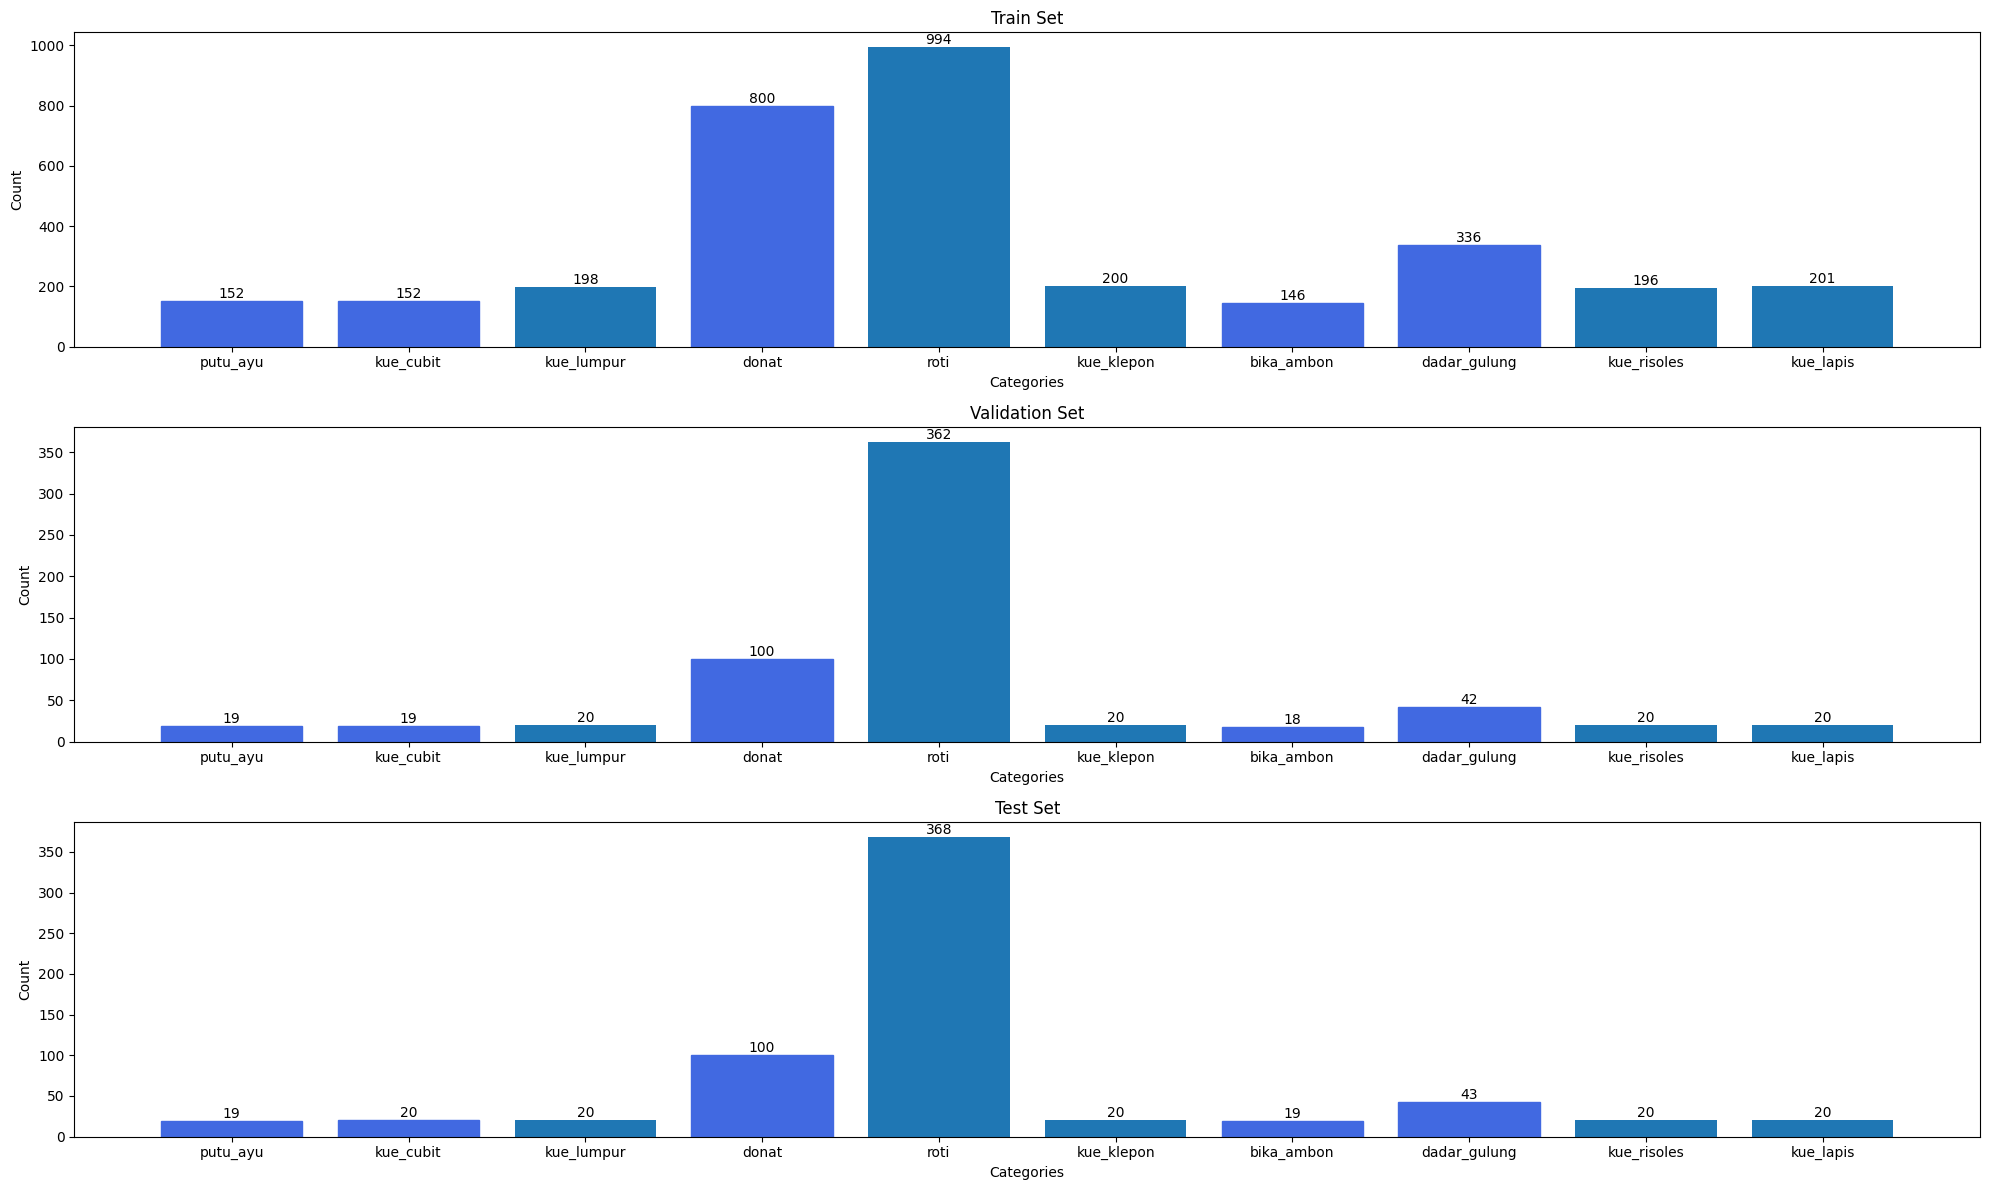

In [13]:
dataset_folder = base_dir
categories = os.listdir(os.path.join(base_dir, 'train'))

data_splits = ['train', 'validation', 'test']

counts = {split: {category: 0 for category in categories} for split in data_splits}

for split in data_splits:
    for category in categories:
        category_folder = os.path.join(dataset_folder, split, category)
        counts[split][category] = len(os.listdir(category_folder))

fig, axes = plt.subplots(3, 1, figsize=(20, 12))

for i, split in enumerate(data_splits):
    ax = axes[i]
    categories_counts = [counts[split][category] for category in categories]
    bars = ax.bar(categories, categories_counts)
    ax.set_title(f'{split.capitalize()} Set')
    ax.set_xlabel('Categories')
    ax.set_ylabel('Count')

    for i in not_splitted:
      i = i.lower().replace(" ", "_")
      bars[categories.index(i)].set_color('royalblue')

    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{height}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

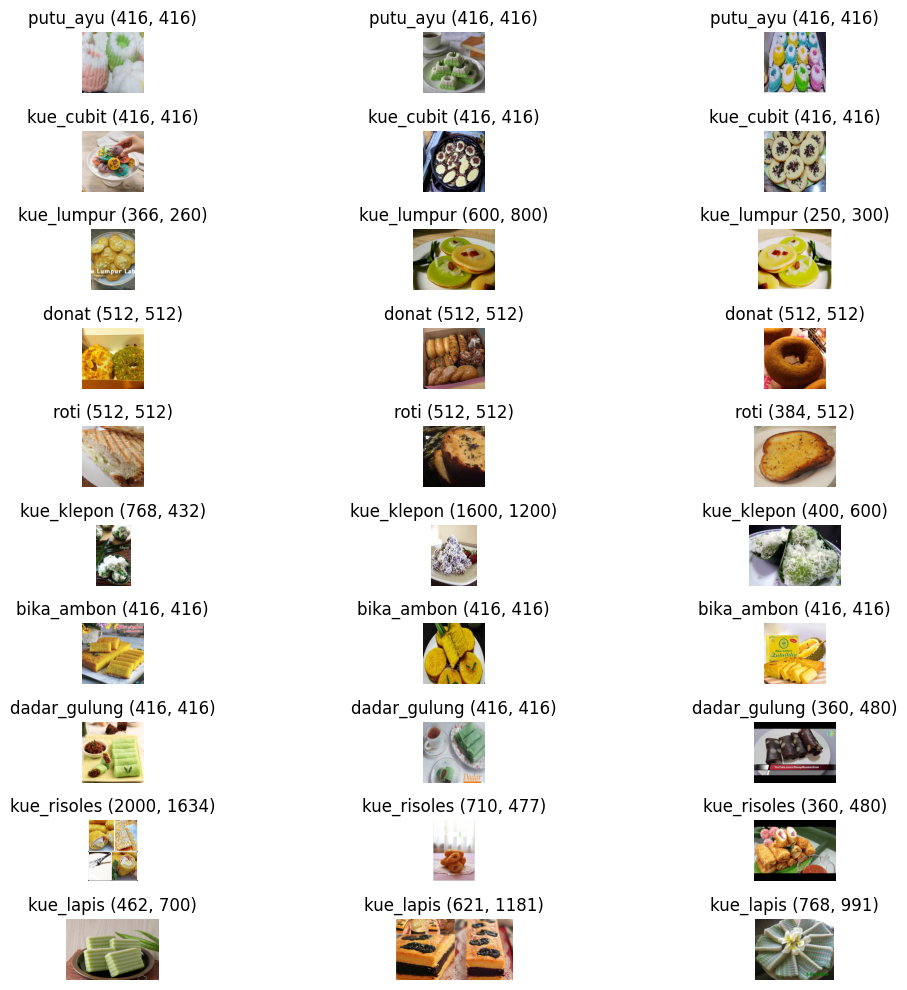

In [14]:
class_count = len(categories)
examples = 3

fig, ax = plt.subplots(class_count, examples, figsize=(12, 10))


for i, category in enumerate(categories):
  category_dir = os.path.join(base_dir, 'train', category)
  image_files = os.listdir(category_dir)

  for j in range(examples):
    rdm = np.random.randint(0, len(image_files))
    img_path = os.path.join(category_dir, image_files[rdm])
    img = mpimg.imread(img_path)
    ax[i, j].imshow(img)
    ax[i, j].set_title(f'{category} {img.shape[:2]}')
    ax[i, j].axis('off')

plt.tight_layout()

plt.show()

## Data Augmentation

In [15]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

training_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(rescale = 1./255)
train_generator = training_datagen.flow_from_directory(
	train_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)

validation_generator = validation_datagen.flow_from_directory(
	validation_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)

test_generator = validation_datagen.flow_from_directory(
	test_dir,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=32
)

Found 3371 images belonging to 10 classes.
Found 640 images belonging to 10 classes.
Found 649 images belonging to 10 classes.


## Building Model

In [16]:
input_shape = (150, 150, 3)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

In [17]:
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Model Training

In [18]:
history = model.fit(train_generator, epochs=25, validation_data = validation_generator)

Epoch 1/25
106/106 [==============================] - 47s 320ms/step - loss: 1.9245 - accuracy: 0.3290 - val_loss: 1.5170 - val_accuracy: 0.5219
Epoch 2/25
106/106 [==============================] - 35s 328ms/step - loss: 1.5884 - accuracy: 0.4239 - val_loss: 1.2630 - val_accuracy: 0.5078
Epoch 3/25
106/106 [==============================] - 33s 309ms/step - loss: 1.5119 - accuracy: 0.4444 - val_loss: 1.1424 - val_accuracy: 0.6281
Epoch 4/25
106/106 [==============================] - 34s 325ms/step - loss: 1.4567 - accuracy: 0.4640 - val_loss: 1.1810 - val_accuracy: 0.5719
Epoch 5/25
106/106 [==============================] - 33s 314ms/step - loss: 1.4184 - accuracy: 0.4743 - val_loss: 1.1163 - val_accuracy: 0.6016
Epoch 6/25
106/106 [==============================] - 33s 312ms/step - loss: 1.4150 - accuracy: 0.4767 - val_loss: 1.0815 - val_accuracy: 0.6203
Epoch 7/25
106/106 [==============================] - 35s 328ms/step - loss: 1.3658 - accuracy: 0.4996 - val_loss: 1.2963 - val_ac

## Model Evaluation

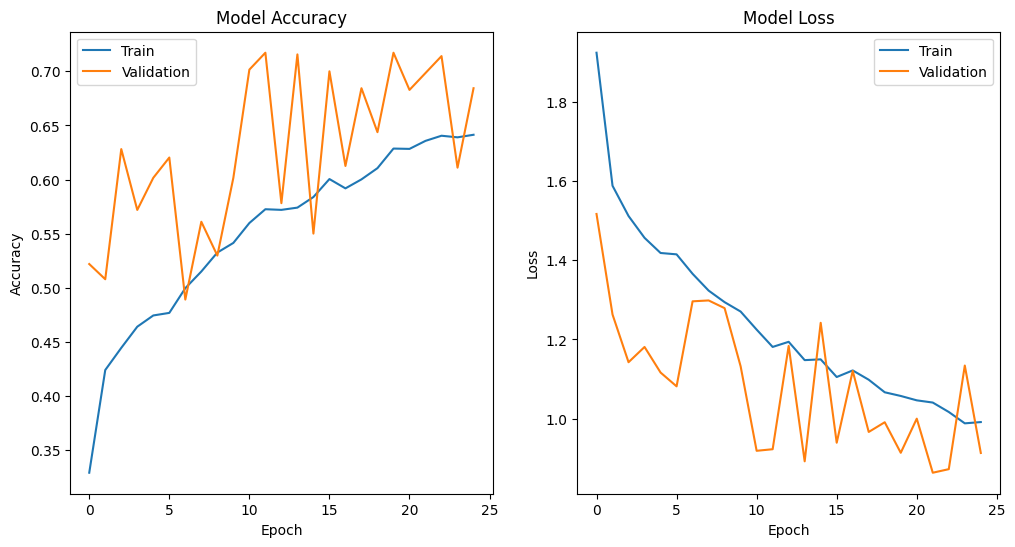

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [21]:
results = model.evaluate(test_generator, batch_size=32)

21/21 [==============================] - 4s 167ms/step - loss: 0.9448 - accuracy: 0.6780


## Transfer Learning

In [22]:
resnet_model = tf.keras.applications.ResNet50V2(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)

94668760/94668760 [==============================] - 1s 0us/step


In [23]:
resnet_model.trainable = False

In [33]:
# create a new model on top layers
inputs = tf.keras.Input(shape=input_shape)
x = resnet_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(10, activation="softmax")(x)
tl_model = tf.keras.Model(inputs=inputs, outputs=outputs)
tl_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d_3  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_5 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23585290 (89.97 MB)
Trainable params: 20490 (80.04 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [34]:
tl_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [35]:
tl_hist = tl_model.fit(
    train_generator,
    epochs = 25,
    validation_data = validation_generator,
)

Epoch 1/25
106/106 [==============================] - 41s 343ms/step - loss: 1.4023 - accuracy: 0.5503 - val_loss: 0.6640 - val_accuracy: 0.7750
Epoch 2/25
106/106 [==============================] - 39s 364ms/step - loss: 0.8229 - accuracy: 0.7274 - val_loss: 0.4970 - val_accuracy: 0.8297
Epoch 3/25
106/106 [==============================] - 36s 338ms/step - loss: 0.7259 - accuracy: 0.7544 - val_loss: 0.4750 - val_accuracy: 0.8359
Epoch 4/25
106/106 [==============================] - 36s 341ms/step - loss: 0.6633 - accuracy: 0.7781 - val_loss: 0.5161 - val_accuracy: 0.8359
Epoch 5/25
106/106 [==============================] - 35s 333ms/step - loss: 0.6009 - accuracy: 0.8027 - val_loss: 0.4181 - val_accuracy: 0.8719
Epoch 6/25
106/106 [==============================] - 36s 336ms/step - loss: 0.5938 - accuracy: 0.7977 - val_loss: 0.4459 - val_accuracy: 0.8594
Epoch 7/25
106/106 [==============================] - 35s 333ms/step - loss: 0.5612 - accuracy: 0.8122 - val_loss: 0.4174 - val_ac

## Model Evaluation

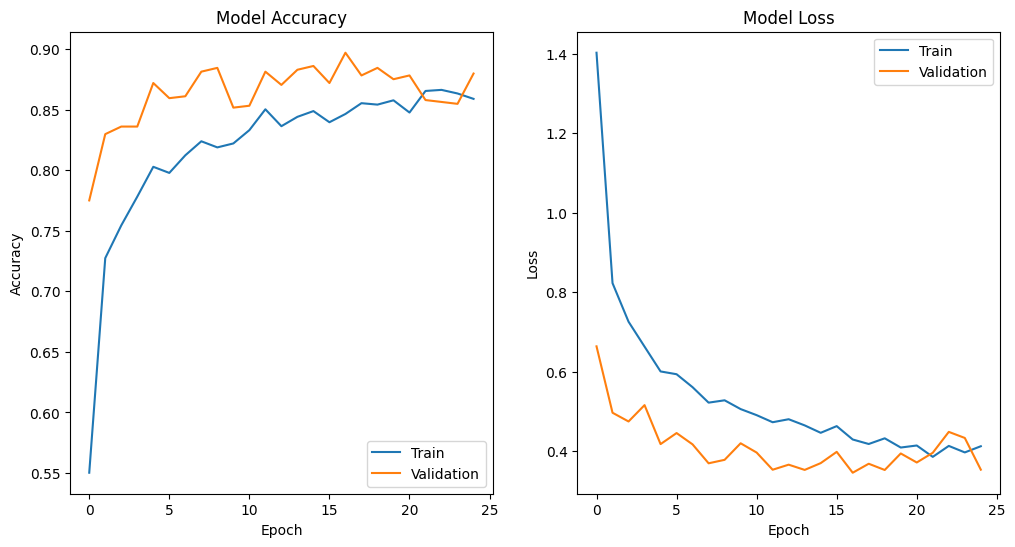

In [36]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(tl_hist.history['accuracy'])
plt.plot(tl_hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(tl_hist.history['loss'])
plt.plot(tl_hist.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

In [57]:
results = tl_model.evaluate(test_generator, batch_size=32)

21/21 [==============================] - 4s 193ms/step - loss: 0.4364 - accuracy: 0.8814


## Save Model

In [59]:
import tempfile

MODEL_DIR = tempfile.gettempdir()
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))

tf.keras.models.save_model(
    model,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)

print('\nSaved model:')
!ls -l {export_path}

export_path = /tmp/1


Saved model:
total 188
drwxr-xr-x 2 root root   4096 Nov 29 14:12 assets
-rw-r--r-- 1 root root     55 Nov 29 14:12 fingerprint.pb
-rw-r--r-- 1 root root  25210 Nov 29 14:12 keras_metadata.pb
-rw-r--r-- 1 root root 149371 Nov 29 14:12 saved_model.pb
drwxr-xr-x 2 root root   4096 Nov 29 14:12 variables


## Summary

Thank you!